In [1]:
import pandas as pd
import numpy as np
import evaluate
df = pd.read_csv('data/data_after_preprocessing.csv')

Things to take note before using this modelling notebook

1. There are 2 approaches to using the text corpus  
    a. LDA: Hard to explain because clusters are not labelled but dimensionality has been reduced to 5 (based on grid)  
    b. TFIDF: 173 (based on vectorizer) tfidf float numbers exist per tweet. Easier explanability but high dimensionality)  
2. A new feature "day_after" has been added. Remember to include it in the modelling step if you wish to.  
3. Remember to do scaling on numerical features.

### Data Preprocessing

#### Text Processing

In [2]:
# Lemmatization
import nltk
nltk.download('wordnet')

from nltk.stem.wordnet import WordNetLemmatizer
df['tweet'] = df['tweet'].apply(lambda x:' '.join(WordNetLemmatizer().lemmatize(i) for i in x.split(' ')))

# Remove punctuation
df['tweet'] = df['tweet'].str.replace('[^\w\s]','')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\flyxs\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\users\flyxs\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':


In [3]:
# Run tf vectorizer

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

# Adding a list of stop words to the wordlist
my_stop_words = text.ENGLISH_STOP_WORDS.union(['suicidal'])

count_vectorizer = CountVectorizer(min_df=0.01, stop_words=my_stop_words)

# Use vectors for LDA

x = count_vectorizer.fit_transform(df['tweet'])
lda_model = LatentDirichletAllocation(n_components=5, learning_decay=0.7, random_state=2021)
xtr = lda_model.fit_transform(x)

# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(x))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(x))

data_x = pd.DataFrame(xtr).add_prefix('topic_')

Log Likelihood:  -234533.78816095446
Perplexity:  146.79236506626245


In [4]:
pd.DataFrame(count_vectorizer.vocabulary_.items()).sort_values(1,ascending=False)[:10]

,0,1
112,youre,175
58,young,174
77,yes,173
15,year,172
162,yeah,171
66,wrong,170
109,worse,169
36,world,168
59,work,167
71,wont,166


In [5]:
from sklearn import preprocessing ,model_selection

# Take log for some features and generate data_x
features_to_log = ['nlikes', 'nreplies', 'nretweets', 'tweets', 'following', 'followers', 'likes', 'media']
for feature in features_to_log:
    data_x[feature] = np.log1p(df[feature])
    
# 'day' take absolute values.
df['day'] = (df['day'] - 4).abs()

# Adding features
features_to_add = ['day','reply_to', 'url','join_time', 'day_after','tweet_length', 'tweet_sentiment', 'bio_sentiment', 'first_person', 'second_person', 'third_person']
for feature in features_to_add:
    data_x[feature] = df[feature]
    
scaler = preprocessing.MinMaxScaler()
data_x.iloc[:, 5:] = scaler.fit_transform(data_x.iloc[:, 5:])
data_y = df['label']

In [6]:
# train test split
x_train, x_test, y_train, y_test = model_selection.train_test_split(data_x, data_y, test_size = 0.2, random_state = 2021)

### Modelling with all features

##### Logistics Regression

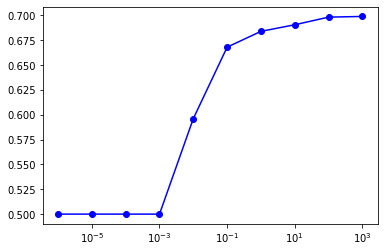

In [7]:
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics
num_C = 10
C = [1.0] * num_C
for i in range(num_C):
    C[i] = pow(10, i - 6)
logit_multi = [0] * num_C
precision = [0] * num_C
recall = [0] * num_C
auc = [0] * num_C

for i in range(num_C):
    logit_multi[i] = linear_model.LogisticRegression(
        C=C[i],
        max_iter=1000)
    logit_multi[i].fit(x_train, y_train)
    auc[i] = metrics.roc_auc_score(y_test, logit_multi[i].predict(x_test))

plt.xscale('log')
plt.plot(C, auc, 'bo-')
plt.show()

In [8]:
# Select C = 0.01
estimator = linear_model.LogisticRegression(class_weight='balanced', C=0.1, max_iter=1000)

estimator.fit(x_train, y_train)
y_pred_proba = estimator.predict_proba(x_test)
dic = evaluate.threshold(y_pred_proba,y_test)
print('Selected threshold: ', dic['threshold'])
print(evaluate.performance(y_test, dic['y_pred'],y_pred_proba)['report'])

Selected threshold:  0.43

The evaluation report of classification is:
Confusion Matrix:
[[997 449]
 [ 47 355]]
Accuracy: 0.7316017316017316
Precision: 0.44154228855721395
Recall: 0.8830845771144279
F2 Score: 0.7359038142620233
AUC Score: 0.8548474776876336



### Modelling with real time available features
data in this part will have no features in 'nlikes', 'nreplies', 'nretweets' and 'day_after' becasue these features are received a few days after the tweets were posted.

In [9]:
x_train_rt = x_train.drop(columns=['nlikes', 'nreplies', 'nretweets', 'day_after'])
x_test_rt = x_test.drop(columns=['nlikes', 'nreplies', 'nretweets', 'day_after'])

In [10]:
# Model implementation
estimator = linear_model.LogisticRegression(class_weight='balanced', C=0.1, max_iter=1000)

estimator.fit(x_train_rt, y_train)
y_pred_proba = estimator.predict_proba(x_test_rt)
dic = evaluate.threshold(y_pred_proba,y_test)
print('Selected threshold: ', dic['threshold'])
print(evaluate.performance(y_test, dic['y_pred'],y_pred_proba)['report'])

Selected threshold:  0.44

The evaluation report of classification is:
Confusion Matrix:
[[1009  437]
 [  52  350]]
Accuracy: 0.7353896103896104
Precision: 0.44472681067344344
Recall: 0.8706467661691543
F2 Score: 0.7306889352818371
AUC Score: 0.8521758427778123



### Modelling using only tweet
Other than using a LSTM to implement the classifier solely on tweet, we also try a mechine learning approach on tweet.  
Using the count_vectorizer, we perform a naive bayes to classify.  

In [11]:
x_train_2, x_test_2, y_train_2, y_test_2 = model_selection.train_test_split(df['tweet'], df['label'], test_size = 0.2, random_state = 2021)
count = CountVectorizer(min_df=0.01, stop_words=my_stop_words)
x_train_2 = count.fit_transform(x_train_2)
x_test_2 = count.transform(x_test_2)

from sklearn import naive_bayes

mnb = naive_bayes.MultinomialNB()
mnb.fit(x_train_2, y_train_2)
y_pred_proba = mnb.predict_proba(x_test_2)
dic = evaluate.threshold(y_pred_proba,y_test)
print('Selected threshold: ', dic['threshold'])
print(evaluate.performance(y_test, dic['y_pred'],y_pred_proba)['report'])

Selected threshold:  0.14

The evaluation report of classification is:
Confusion Matrix:
[[692 754]
 [ 36 366]]
Accuracy: 0.5725108225108225
Precision: 0.3267857142857143
Recall: 0.9104477611940298
F2 Score: 0.6708211143695014
AUC Score: 0.7933732100218134



In [12]:
neg_class_keyword = mnb.feature_log_prob_[0, :].argsort()[::-1]
pos_class_keyword = mnb.feature_log_prob_[1, :].argsort()[::-1]
print(np.take(count.get_feature_names(),neg_class_keyword[:10]))
print(np.take(count.get_feature_names(),pos_class_keyword[:10]))

['wa' 'people' 'like' 'just' 'thought' 'dont' 'im' 'suicide' 'amp' 'help']
['im' 'thought' 'wa' 'just' 'like' 'dont' 'feel' 'tw' 'want' 'ive']


#### Save the model

In [13]:
import pickle

with open('naive_bayes_model/nbmodel.pkl','wb') as f:
    pickle.dump(mnb,f)

with open('naive_bayes_model/cvmodel.pkl','wb') as f:
    pickle.dump(count,f)